## We now attempt to find out if the way a SEC filing is done has an effect on the returns

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# Remove warnings to keep outputs clean
warnings.filterwarnings("ignore")

PROCESSED_DATA_FOLDER = "../../data_untracked/processed"
ABNORMAL_CSV = "snorkel_labels.csv"

COMPILED_DATA_FOLDER = "../../data_untracked/raw/sec_submissions/compiled"
FOOTNOTES_CSV = "FOOTNOTES.csv"

In [2]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download("wordnet")
# nltk.download("averaged_perceptron_tagger")

## Load required datasets
1. `snorkel_labels.csv`: Transactions with their Cumulative Abnormal Returns (CAR)
2. `FOOTNOTES.csv`: Each transactions with their individual filing comments

In [3]:
abnormal_transactions = pd.read_csv(f'{PROCESSED_DATA_FOLDER}/{ABNORMAL_CSV}')[["ACCESSION_NUMBER", "TRANS_CODE", "TRANS_ACQUIRED_DISP_CD", "snorkel_prob", "snorkel_pred"]]
abnormal_transactions = abnormal_transactions.rename(columns={"snorkel_prob" : "probability",
                                                               "snorkel_pred" : "prediction"})
footnotes = pd.read_csv(f'{COMPILED_DATA_FOLDER}/{FOOTNOTES_CSV}')
print("Loading data")

Loading data


In [4]:
print(abnormal_transactions.shape)
print(footnotes.shape)

(778559, 5)
(6453264, 3)


In [5]:
footnotes.head()

,ACCESSION_NUMBER,FOOTNOTE_ID,FOOTNOTE_TXT
0,0001179110-14-011078,F1,Sale made pursuant to a Rule 10b5-1 Plan dated...
1,0001179110-14-011078,F2,Shares adjusted for those withheld to cover ta...
2,0001144204-14-040534,F3,"Includes 2,106 shares of common stock received..."
3,0001144204-14-040534,F2,Restricted shares of common stock issued pursu...
4,0001144204-14-040534,F1,Shares issued in lieu of cash for board services.


In [6]:
df_footnote = footnotes.copy()
df_footnote = df_footnote.sort_values(by=["ACCESSION_NUMBER", "FOOTNOTE_ID"])
df_footnote["FOOTNOTE_TXT"] = df_footnote["FOOTNOTE_TXT"].astype(str)
df_grouped = df_footnote.groupby("ACCESSION_NUMBER", sort=True)["FOOTNOTE_TXT"].apply(lambda x: " ".join(x)).reset_index()
df_grouped

,ACCESSION_NUMBER,FOOTNOTE_TXT
0,0000002178-18-000032,The reporting person received a grant of 375 r...
1,0000002178-18-000042,The reporting person received a grant of 375 r...
2,0000002178-18-000043,The reporting person received a grant of 375 r...
3,0000002178-18-000044,The reporting person received a grant of 375 r...
4,0000002178-18-000045,The reporting person received a grant of 875 r...
...,...,...
2416566,0002049094-24-000001,(1)This statement is jointly filed by and on b...
2416567,0002049094-24-000002,(1) The price reported represents the weighted...
2416568,0002049094-24-000003,The price reported represents the weighted ave...
2416569,0002049094-24-000004,The price reported represents the weighted ave...


In [7]:
df_footnote_combined = pd.merge(abnormal_transactions, df_grouped, how = "left", left_on = "ACCESSION_NUMBER", right_on = "ACCESSION_NUMBER")
df_footnote_combined = df_footnote_combined[df_footnote_combined["FOOTNOTE_TXT"].notnull()]
df_footnote_combined.head()

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,probability,prediction,FOOTNOTE_TXT
2,0000919574-19-000485,P,A,0.478567,0,The Form 3 filed by the Reporting Persons inco...
3,0000919574-19-000485,P,A,0.478567,0,The Form 3 filed by the Reporting Persons inco...
4,0000919574-19-000485,P,A,0.478567,0,The Form 3 filed by the Reporting Persons inco...
764,0001209191-14-041289,S,D,0.893302,1,Represents shares beneficially owned by the Al...
765,0001209191-14-041289,S,D,0.893302,1,Represents shares beneficially owned by the Al...


## We look at CAR 60 before and after. We would find the value by multiplying by 1 of its acquire and -1 if its dispose

In [8]:
df_footnote_exist_drop = df_footnote_combined.dropna(subset=["prediction"]).dropna(subset=["FOOTNOTE_TXT"])
df_footnote_exist_drop = df_footnote_exist_drop.drop_duplicates(subset=["ACCESSION_NUMBER"])
df_footnote_exist_drop.shape

(129350, 6)

In [23]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
stop_words.update(["shall", "should"])

In [24]:
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith("J"):  # Adjective
        return wordnet.ADJ
    elif nltk_tag.startswith("N"):  # Noun
        return wordnet.NOUN
    elif nltk_tag.startswith("V"):  # Verb
        return wordnet.VERB
    elif nltk_tag.startswith("R"):  # Adverb
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if unknown

In [25]:
def lemmatize_text(text):
    words = word_tokenize(text)  # Tokenize text
    tagged_words = pos_tag(words)  # POS tagging

    lemmatized_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_words if lemmatizer.lemmatize(word, get_wordnet_pos(tag)) not in  stop_words
    ]

    return " ".join(lemmatized_words)  # Reconstruct sentence

In [30]:
def remove_words(text):
    text = re.sub(r"\(.*\)", "", text)
    text = re.sub(r"[0-9,.%\$\"\(\)\/_]+", "", text)
    text = re.sub(r"(january|february|march|april|may|june|july|august|september|october|november|december)", "", text)
    return text

In [ ]:
def preprocess_text(text):
    text = text.lower()
    removed_unecessary_text = remove_words(text)
    lemmatized_text = lemmatize_text(removed_unecessary_text)

    return lemmatized_text

In [33]:
lemmatized_text = lemmatize_text("The striped cats were running quickly towards the biggest house.") 
# Output: "The stripe cat be run quickly towards the big house ."

In [34]:
preprocess_text("This transaction was executed in multiple trades at prices ranging from $38.17 to $38.73. The price reported above reflects the weighted average sale price. The reporting person hereby undertakes to provide upon request to the SEC staff, the issuer or a security holder of the issuer full information regarding the number of shares and prices at which the transaction was effected.")

'transaction execute multiple trade price range price report reflect weighted average sale price report person hereby undertakes provide upon request sec staff issuer security holder issuer full information regard number share price transaction effect'

## Find in samples

In [37]:
df_footnote_labels = df_footnote_exist_drop.copy()
df1, df2 = train_test_split(df_footnote_labels, test_size=0.25, random_state=4263)
sampled_df = df1
sampled_df.shape

(97012, 6)

In [39]:
sampled_df

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,probability,prediction,FOOTNOTE_TXT
612633,0001179110-18-011384,S,D,1.000000,1,This transaction was executed in multiple sale...
607376,0001209191-13-020246,S,D,0.877577,1,Pursuant to 10b5-1 plan.
33142,0001044321-13-000081,P,A,0.599162,1,This is a weighted average price. This is a jo...
644773,0001209191-18-043784,J,A,0.248844,0,Represents the 2017 ESOP allocation reflected ...
418889,0001437749-19-011812,S,D,0.545646,1,In accordance with the reporting person's 10b5...
...,...,...,...,...,...,...
204287,0001140361-18-031055,P,A,0.893302,1,"Represents restricted stock units (""RSUs"") tha..."
548243,0001562180-19-005997,G,D,0.893302,1,This transaction was executed in multiple trad...
668626,0001104659-19-033425,S,D,1.000000,1,This transaction was executed in multiple trad...
18095,0001144204-14-027352,S,D,0.893302,1,This transaction relates to the distribution a...


In [57]:
test = sampled_df.head()
test["processed_txt"] = test["FOOTNOTE_TXT"].apply(lambda row: preprocess_text(row))
test

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,probability,prediction,FOOTNOTE_TXT,processed_txt
612633,0001179110-18-011384,S,D,1.000000,1,This transaction was executed in multiple sale...,transaction execute multiple sale sale order e...
607376,0001209191-13-020246,S,D,0.877577,1,Pursuant to 10b5-1 plan.,pursuant b- plan
33142,0001044321-13-000081,P,A,0.599162,1,This is a weighted average price. This is a jo...,weighted average price joint filing austin w m...
644773,0001209191-18-043784,J,A,0.248844,0,Represents the 2017 ESOP allocation reflected ...,represent esop allocation reflect report owner...
418889,0001437749-19-011812,S,D,0.545646,1,In accordance with the reporting person's 10b5...,accordance report person 's b- trading plan


In [77]:
text = sampled_df["FOOTNOTE_TXT"]
sampled_df["processed_txt"] = sampled_df["FOOTNOTE_TXT"].apply(lambda row: preprocess_text(row))

# processed = np.array([preprocess_text(x) for x in text])
vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True, max_features=500)
X = vectorizer.fit_transform(sampled_df["processed_txt"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


In [68]:
sampled_df["prediction"]

612633    1
607376    1
33142     1
644773    0
418889    1
         ..
204287    1
548243    1
668626    1
18095     1
310291    1
Name: prediction, Length: 97012, dtype: int64

In [66]:
tfidf_df.head()

,accordance,account,accrue,achieve,achievement,acquire,acquisition,act,actual,actually,...,weight,weighted,wholly,wife,withhold,withholding,write,year,york,prediction
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.121002,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.138458,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.217273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.378657,0.0,NaN
4,0.791811,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN


In [69]:
tfidf_df["prediction"] = sampled_df["prediction"]

In [74]:
tfidf_df["prediction"]

0        NaN
1        NaN
2        0.0
3        NaN
4        NaN
        ... 
97007    NaN
97008    NaN
97009    NaN
97010    NaN
97011    NaN
Name: prediction, Length: 97012, dtype: float64

In [71]:
# Sort the suspicious words for non-j coded items

suspicius = tfidf_df[tfidf_df['prediction'] == 1].drop(columns=["prediction"]).mean()
non_suspicious = tfidf_df[tfidf_df['prediction'] == 0].drop(columns=["prediction"]).mean()
suspicious_words = (suspicius - non_suspicious).sort_values(ascending=False)

In [72]:
df_j_coded = df_footnote_labels[df_footnote_labels["TRANS_CODE"] == "J"]
df_j_coded.head()

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,probability,prediction,FOOTNOTE_TXT
768,0001209191-19-008111,J,D,0.893302,1,The transactions reported on this Form relate ...
769,0001214659-17-003850,J,A,0.599162,1,This statement is jointly filed by Royal Bank ...
770,0001214659-19-003175,J,A,0.635810,1,This statement is jointly filed by Royal Bank ...
828,0001144204-13-022258,J,A,0.208968,0,See Exhibit 99.1; Note 1. See Exhibit 99.1; No...
1329,0001181431-13-021969,J,D,0.893302,1,"New Enterprise Associates 13, L.P. (""NEA 13"") ..."


In [73]:
text_j = df_j_coded["FOOTNOTE_TXT"]
processed = np.array([preprocess_text(x) for x in text_j])
vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True, max_features=500)
X = vectorizer.fit_transform(processed)

# Convert to DataFrame
tfidf_df_j = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [50]:
tfidf_df_j["prediction"] = df_j_coded["prediction"]
tfidf_df_j.head()

,aap,accel,accordance,account,accrue,achieve,achievement,acquire,acquisition,act,...,wholly,wife,withhold,withholding,xi,xii,year,york,yorktown,prediction
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.141256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [51]:
suspicius_j = tfidf_df_j[tfidf_df_j['prediction'] == 1].drop(columns=["prediction"]).mean()
non_suspicious_j = tfidf_df_j[tfidf_df_j['prediction'] == 0].drop(columns=["prediction"]).mean()
suspicious_words_j = (suspicius_j - non_suspicious_j).sort_values(ascending=False)

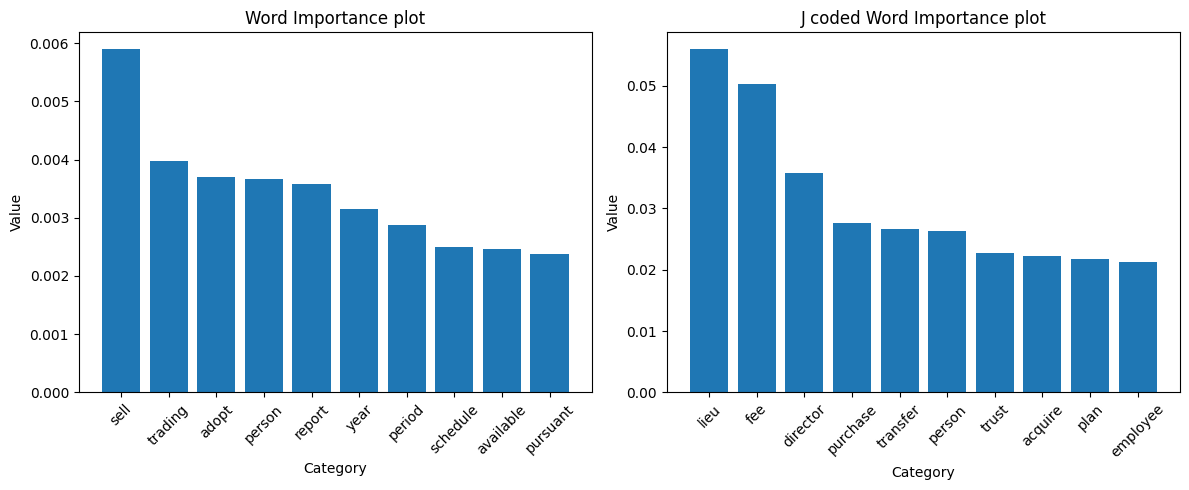

In [52]:
# Top 10 suspicious words Non-J coded and J coded
top_10_data = suspicious_words.head(10)
top_10_data_j = suspicious_words_j.head(10)

plt.figure(figsize=(12, 5))

########################
# Plot Non-J coded word importance
########################
plt.subplot(1, 2, 1)
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Word Importance plot')
plt.bar(top_10_data.index, top_10_data.values)
plt.xticks(rotation=45)

########################
# Plot J coded word importance
########################
plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('J coded Word Importance plot')
plt.bar(top_10_data_j.index, top_10_data_j.values)

# Adjust layout and show
plt.tight_layout()
plt.show()


___
## Importance of features
___

### Feature creation:

In [48]:
def count_lemmatized(row, string):
    lemmatizer = WordNetLemmatizer()
    # print(row)
    words = word_tokenize(row.lower())
    counter = 0
    for word in words:
        if string == lemmatizer.lemmatize(word):
            counter += 1
    return counter

In [49]:
df_features

NameError: name 'df_features' is not defined

In [53]:
WordNetLemmatizer().lemmatize("trading", pos=wordnet.VERB)

'trade'

In [ ]:
text_list = ["forced sale", "gift", "distribution", "charity", "10b5-1", "16b-3"]
text_from_keywords = ["sell", "trading", "lieu", "fee"]
text_list.extend(text_from_keywords)
df_features = df_footnote_labels.copy()

for t in text_list:
    df_features[t] = df_features["FOOTNOTE_TXT"].apply(lambda row: count_lemmatized(row, t))
    
    # np.where(df_features["FOOTNOTE_TXT"].str.count(t), 1, 0)

text_list = text_list + ["anomaly_120", "label"]
df_features = df_features[text_list]
df_features.head()

,forced sale,gift,distribution,charity,10b5-1,16b-3,executed,trade,dividend,restricted,anomaly_120,label
0,0,0,0,0,0,0,0,0,0,0,-12.905019,0
1,0,0,0,0,1,1,0,0,0,0,-11.027958,0
2,0,0,0,0,1,0,0,0,0,0,-7.327263,0
3,0,0,0,0,1,1,0,0,0,0,-9.187093,0
4,0,0,0,0,1,1,0,0,0,0,-8.289322,0


In [ ]:
df_features.to_csv("word_count.csv")

In [ ]:
print(text_list)

['forced sale', 'gift', 'distribution', 'charity', '10b5-1', '16b-3', 'executed', 'trade', 'dividend', 'restricted', 'anomaly_120', 'label']


In [ ]:
for col in df_features.columns:
    if col == "label" or col == "anomaly_120":
        continue
    print(f'{col}: {sum(df_features[col])}')

forced sale: 0
gift: 5472
distribution: 7687
charity: 217
10b5-1: 337430
16b-3: 20032
executed: 198020
trade: 196999
dividend: 80038
restricted: 243223


In [ ]:
##################################
# Define functions
##################################

def compare_complement(df, col, metrics):
    split_1 = df[df[col] >= 1]
    split_2 = df[df[col] < 1]
    
    for metric in metrics:
        A = split_1[metric].dropna()
        
        # print(A)
        B = split_2[metric].dropna()
        t_stat, p_val = stats.ttest_ind(A, B, equal_var=False)
        sign = "negative" if t_stat < 0 else "positive"
        print(f"{metric}: is more {sign} when {col} is separated\n" 
              f"t-statistic = {t_stat}, p-value = {p_val}\n"
              f"mean {col} = {np.mean(A)}, mean {col} complement = {np.mean(B)}\n")
        
    print(f"{col}: n = {len(A)}, {col} complement: n = {len(B)}\n")

def compare_columns(df, col1, col2, metrics):
    split_1 = df[df[col1] == 1]
    split_2 = df[df[col2] == 1]
    
    for metric in metrics:
        A = split_1[metric].dropna()
        
        # print(A)
        B = split_2[metric].dropna()
        t_stat, p_val = stats.ttest_ind(A, B, equal_var=False)
        sign = "negative" if t_stat < 0 else "positive"
        print(f"{metric}: is more {sign} when {col1} compared to {col2}\n" 
              f"t-statistic = {t_stat}, p-value = {p_val}\n"
              f"mean {col1} = {np.mean(A)}, mean {col2} = {np.mean(B)}\n")
    print(f"{col1}: n = {len(A)}, {col2} : n = {len(B)}")

In [ ]:
compare_complement(df_features,"executed", ["anomaly_120"])

anomaly_120: is more positive when executed is separated
t-statistic = 8.440625021767072, p-value = 3.2098523767567755e-17
mean executed = -4.664311242557403, mean executed complement = -8.227731884015604

executed: n = 61970, executed complement: n = 551944



In [ ]:
compare_complement(df_features,"trade", ["anomaly_120"])

anomaly_120: is more positive when trade is separated
t-statistic = 0.26906833366102045, p-value = 0.7878778339198579
mean trade = -7.763570667004628, mean trade complement = -7.879517165242578

trade: n = 60815, trade complement: n = 553099



In [ ]:
compare_complement(df_features,"dividend", ["anomaly_120"])

anomaly_120: is more negative when dividend is separated
t-statistic = -5.923079637844038, p-value = 3.1790579290093855e-09
mean dividend = -10.723522967663836, mean dividend complement = -7.6355618467173025

dividend: n = 46217, dividend complement: n = 567697



In [ ]:
compare_complement(df_features,"restricted", ["anomaly_120"])

anomaly_120: is more positive when restricted is separated
t-statistic = 3.627353377935459, p-value = 0.0002864280242285236
mean restricted = -6.836232331219486, mean restricted complement = -8.10508858100237

restricted: n = 114696, restricted complement: n = 499218



In [ ]:
compare_complement(df_features,"restricted", ["anomaly_120"])

anomaly_120: is more positive when restricted is separated
t-statistic = 3.627353377935459, p-value = 0.0002864280242285236
mean restricted = -6.836232331219486, mean restricted complement = -8.10508858100237

restricted: n = 114696, restricted complement: n = 499218



In [ ]:
compare_complement(df_features, "forced sale", ["anomaly_120"])

anomaly_120: is more positive when forced sale is separated
t-statistic = nan, p-value = nan
mean forced sale = nan, mean forced sale complement = -7.8680313768579815

forced sale: n = 0, forced sale complement: n = 613914



In [ ]:
compare_complement(df_features, "gift", ["anomaly_120"])

anomaly_120: is more positive when gift is separated
t-statistic = 3.8234216942935983, p-value = 0.00013332753344647336
mean gift = -3.2188461072825922, mean gift complement = -7.902845847311091

gift: n = 4563, gift complement: n = 609351



In [ ]:
compare_complement(df_features, "distribution", ["anomaly_120"])

anomaly_120: is more positive when distribution is separated
t-statistic = 11.50059406974308, p-value = 3.230800323394858e-30
mean distribution = 7.764564343191978, mean distribution complement = -7.98974662840508

distribution: n = 4743, distribution complement: n = 609171



In [ ]:
compare_complement(df_features, "charity", ["anomaly_120"])

anomaly_120: is more negative when charity is separated
t-statistic = -3.5796345399294367, p-value = 0.00043468022477177216
mean charity = -32.73998177472504, mean charity complement = -7.8601286879603185

charity: n = 195, charity complement: n = 613719



In [ ]:
compare_complement(df_features, "10b5-1", ["anomaly_120"])

anomaly_120: is more negative when 10b5-1 is separated
t-statistic = -41.12055170934168, p-value = 0.0
mean 10b5-1 = -13.547889668811667, mean 10b5-1 complement = -2.7879070620388045

10b5-1: n = 289848, 10b5-1 complement: n = 324066



In [ ]:
compare_complement(df_features, "16b-3", ["anomaly_120"])

anomaly_120: is more positive when 16b-3 is separated
t-statistic = 20.874907323376345, p-value = 1.631257520389304e-95
mean 16b-3 = 7.084987081650538, mean 16b-3 complement = -8.246681746072461

16b-3: n = 15162, 16b-3 complement: n = 598752



## Train test split on binary labels

In [ ]:
labels = ["label"]

In [ ]:
df_log = df_features.drop(columns=["anomaly_120"])
df_log = df_log.dropna(subset=labels)
X, y = df_log.drop(columns=labels), df_log[labels]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
print(f"train size x: {train_x.shape}\ntrain size y: {train_y.shape}\ntest size x: {test_x.shape}\ntest size y: {test_y.shape}")

train size x: (506519, 10)
train size y: (506519, 1)
test size x: (126630, 10)
test size y: (126630, 1)


## Fit log regression on labels

In [ ]:
model = LogisticRegression()
result = model.fit(train_x, train_y)
y_pred = model.predict(test_x)

In [ ]:
for i in range(len(model.feature_names_in_)):
    col = model.feature_names_in_[i]
    beta = model.coef_[0][i]
    print(f"{col}: {beta}")

forced sale: 0.0
gift: -0.1614801279140987
distribution: -0.05048799245667638
charity: -0.6575076123015473
10b5-1: -0.15148789095567838
16b-3: -0.04118235503327275
executed: 0.0644857472029892
trade: -0.08065765454230464
dividend: -0.035487784700091715
restricted: 0.038668165902048426


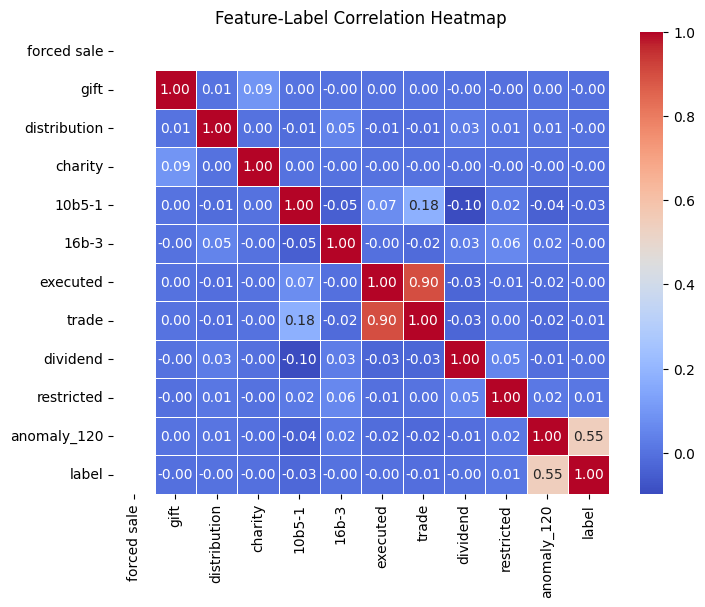

In [ ]:
corr = df_features.corr(method="pearson")
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature-Label Correlation Heatmap")
plt.show()

___
## Fit Regression on labels
___

In [ ]:
temp = df_features.dropna(subset = ["anomaly_120"])
X, y = temp.drop(columns=["label", "anomaly_120"]), temp["anomaly_120"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
print(f"train size x: {train_x.shape}\ntrain size y: {train_y.shape}\ntest size x: {test_x.shape}\ntest size y: {test_y.shape}")

train size x: (491131, 10)
train size y: (491131,)
test size x: (122783, 10)
test size y: (122783,)


In [ ]:
model1 = LinearRegression()
result = model1.fit(train_x, train_y)
y_pred = model1.predict(test_x)

In [ ]:
temp = df_features.dropna(subset=["anomaly_120"])
X, y = temp.drop(columns=["label", "anomaly_120"]), temp["anomaly_120"]

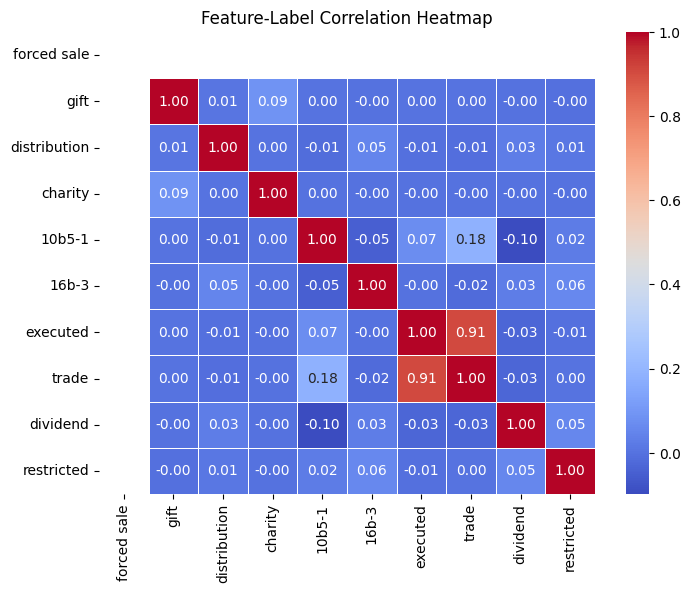

In [ ]:
corr_matrix = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature-Label Correlation Heatmap")
plt.show()


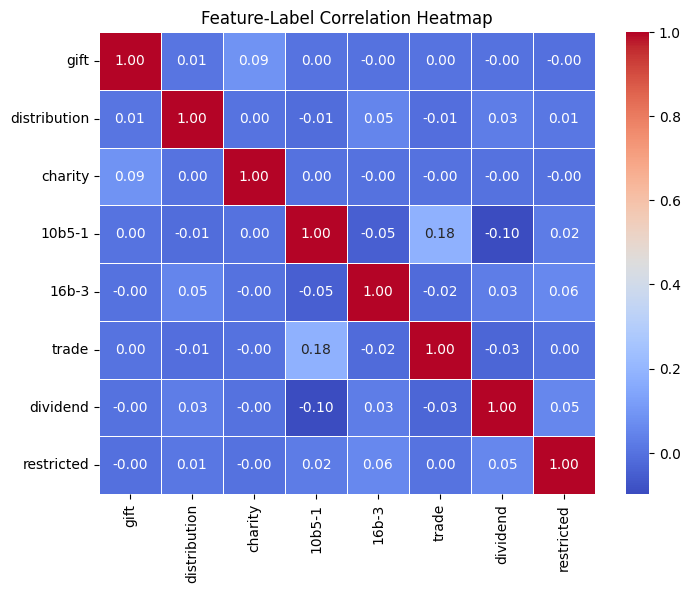

In [ ]:
X = X.drop(columns=["executed", "forced sale"])
corr_matrix = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature-Label Correlation Heatmap")
plt.show()

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
print(f"train size x: {train_x.shape}\ntrain size y: {train_y.shape}\ntest size x: {test_x.shape}\ntest size y: {test_y.shape}")

train size x: (491131, 8)
train size y: (491131,)
test size x: (122783, 8)
test size y: (122783,)


In [ ]:
import statsmodels.api as sm
import numpy as np

# Example Data (same as before)
# Feature (independent variable)
y =  train_y   # Target (dependent variable)
X = train_x
# Add a constant (intercept) term to the feature matrix
X_with_const = sm.add_constant(X)

# Fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X_with_const)
results = model.fit()

# Print the summary of the model
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:            anomaly_120   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     167.6
Date:                Thu, 27 Mar 2025   Prob (F-statistic):          9.32e-284
Time:                        09:14:55   Log-Likelihood:            -2.9696e+06
No. Observations:              491131   AIC:                         5.939e+06
Df Residuals:                  491122   BIC:                         5.939e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.2423      0.190    -27.608   

In [ ]:
y =  train_y * 100   # Target (dependent variable)
X = train_x
# Add a constant (intercept) term to the feature matrix
X_with_const = sm.add_constant(X)

# Fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X_with_const)
results = model.fit()

# Print the summary of the model
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:            anomaly_120   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     167.6
Date:                Thu, 27 Mar 2025   Prob (F-statistic):          9.32e-284
Time:                        09:17:28   Log-Likelihood:            -5.2314e+06
No. Observations:              491131   AIC:                         1.046e+07
Df Residuals:                  491122   BIC:                         1.046e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -524.2254     18.988    -27.608   